### ANALISIS EXPLORATORIO



In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [175]:
#librerias
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
from datetime import date, datetime, timedelta
from os import name

Definición de parámetros iniciales

In [188]:
NUM_OF_WEEK = 8.0
HOURS_OF_DAY = 24
DAYS_OF_WEEK = 7
FORMAT_DATE = '%Y-%m-%d'
DATE_START_TRAINIG = pd.to_datetime("2022-04-13", format=FORMAT_DATE)
FICHERO_DATA = './data/SERVICIO_UNIFICADO_2022.parquet.gzip'

In [189]:
#Se lee el archivo de un parquet a un dataframe
df = pd.read_parquet(FICHERO_DATA) 

print("Dataset cargado con éxito")

Dataset cargado con éxito


Se valida cuantos valores nulos tenemos en el dataset

In [190]:
#Contar cuantos datos se encuentran nulos
df.isnull().sum()

ID                       0
IDCIUDAD                 0
USUARIO               1707
TELEFONOORIGEN       69322
LATITUD                  0
LATITUDDESTINO     1932690
LONGITUD                 0
LONGITUDDESTINO    1932690
ESTADO                   0
ORIGEN                   0
FECHACOMPLETA            0
DIADESEMANA              0
HORA                     0
dtype: int64

Se limpian los datos donde el teléfono del usuario es nulo
 para tener usuarios validos y limitamos los datos de bogotá

In [191]:
df.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,7,19
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,7,19
2,70152582,76001,9243481.0,3147558713,3.367783,NaN,-76.531083,NaN,ABANDONADO,APP,2022-04-30 19:00:01,7,19
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,7,19
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,7,19


In [192]:
#Eliminamos los registros nulos del telefono de origen
df = df[~df['TELEFONOORIGEN'].isnull()]
#Filtramos para ciudad de bogotá
df = df[df["IDCIUDAD"]==11001]

Limitamos los canales por donde se reciben servicios a APP, IVR, CHATBOT, RECEPCIÓN, CALLE Y WEB que son los más relevantes.
Limitamos los estados a ABANDONADO, CUMPLIDO, CANCELADO Y FINALIZADO que son los validos, el restos son errores del proceso.

In [193]:
df = df[(df["ORIGEN"]=="APP") | (df["ORIGEN"]=="IVR") | (df["ORIGEN"]=="CHAT_BOT_659") | (df["ORIGEN"]=="RECEPCION") | (df["ORIGEN"]=="CALLE") | (df["ORIGEN"]=="WEB")]
df = df[(df["ESTADO"]=="ABANDONADO") | (df["ESTADO"]=="CUMPLIDO") | (df["ESTADO"]=="CANCELADO") | (df["ESTADO"]=="FINALIZADO")]

Eliminamos las columnas de ciudad, usuario, id servicio, latitud y longitud de destino

In [194]:
#Se definen las fechas y el día de la semana
df['FECHACOMPLETA'] = pd.to_datetime(df['FECHACOMPLETA'], format='%Y/%m/%d %H:%M:%S')
df['FECHA'] = df['FECHACOMPLETA'].dt.strftime(FORMAT_DATE)
df['DIADESEMANA'] = df['FECHACOMPLETA'].map( lambda x: x.isoweekday() )
df.head(5)

,ID,IDCIUDAD,USUARIO,TELEFONOORIGEN,LATITUD,LATITUDDESTINO,LONGITUD,LONGITUDDESTINO,ESTADO,ORIGEN,FECHACOMPLETA,DIADESEMANA,HORA,FECHA
0,70152580,11001,8946882.0,3186429637,4.642036,4.630580,-74.187636,-74.189880,CANCELADO,APP,2022-04-30 19:00:00,6,19,2022-04-30
1,70152581,11001,9665930.0,3209171095,4.594340,4.604060,-74.138168,-74.141610,ABANDONADO,APP,2022-04-30 19:00:00,6,19,2022-04-30
3,70152583,11001,841805.0,3125733084,4.630927,NaN,-74.092728,NaN,ABANDONADO,CHAT_BOT_659,2022-04-30 19:00:01,6,19,2022-04-30
4,70152584,11001,9330612.0,3043963812,4.548637,4.622711,-74.096414,-74.147018,ABANDONADO,APP,2022-04-30 19:00:01,6,19,2022-04-30
5,70152585,11001,8303036.0,3113623140,4.723984,4.743134,-74.054207,-74.090683,ABANDONADO,APP,2022-04-30 19:00:02,6,19,2022-04-30


In [195]:
#Eliminamos las columan que no son útiles en el modelo
df = df.drop(columns=["IDCIUDAD","USUARIO","ID","LATITUDDESTINO","LONGITUDDESTINO","LATITUD","LONGITUD","FECHACOMPLETA","ORIGEN","ESTADO"])

#Se eliminan los duplicados
df = df.drop_duplicates().sort_values(by=['TELEFONOORIGEN','FECHA','DIADESEMANA','HORA'])
df = df.reset_index(drop=True)
count_data = df.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        783
3138647901        684
3153865158        684
3134579964        642
13148180          628
                 ... 
3125329815          1
3125330004          1
3125330436          1
3125330453          1
999883673           1
Length: 517850, dtype: int64

In [196]:
data = df.copy()




#Se filtran tomando últimas x semanas de la fecha inicial de entrenamiento
date_last_training = DATE_START_TRAINIG - timedelta(weeks=NUM_OF_WEEK)
data = data[ pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > date_last_training ]


#Se descartan los que tienen menos de 10 solicitudes en ese tiempo
data = data.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 10)

#df_train = data[ (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) < DATE_START_TRAINIG) & (pd.to_datetime(data['FECHA'], format=FORMAT_DATE) > date_last_training) ]
#df_train = df_train.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)

#df_test = data[pd.to_datetime(data['FECHA'], format=FORMAT_DATE) >= DATE_START_TRAINIG ]



count_data = data.loc[:,['TELEFONOORIGEN']].value_counts()
count_data

TELEFONOORIGEN
3107584482        564
3153865158        525
3134579964        487
3138647901        485
3002035444        465
                 ... 
3118330587         11
3028348251         11
3118353998         11
3118355887         11
3202755797         11
Length: 60374, dtype: int64

Transformamos el valor de origen y estado a no ordinales con onehot.

In [197]:
# convertimos a  onehot la comuna de origen
#df = pd.get_dummies(df, columns=["ORIGEN"])
# convertimos a  onehot la comuna de estado
#df = pd.get_dummies(df, columns=["ESTADO"])
"""new_df['ORIGEN'] = new_df['ORIGEN'].map( {
        "APP":1,
        "CALLE":2,
        "CHAT_BOT_659":3,
        "CHAT_BOT_689":4,
        "CHAT_BOT_729":5,
        "CHAT_BOT_803":6,
        "EXTERNO":7,
        "IONTAXI":8,
        "IVR":9,
        "NUEVO":10,
        "RECEPCION":11,
        "RED AMARILLA":12,
        "Reserva":13,
        "TELEGRAMTD":14,
        "WEB":15
    } )

new_df['ESTADO'] = new_df['ESTADO'].map( {
        "ABANDONADO":1,
        "ABORDOCONFIRMADO":2,
        "ALFRENTE":3,
        "ASIGNADO": 4,
        "CANCELADO":5,
        "CONFIRMADO":6,
        "CUMPLIDO":7,
        "FINALIZADO": 8,
        "LOCUCION":9,
        "NUEVO":10,
        "RECHAZADO":11
    } )"""
data.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA
248,0000000000,4,3,2022-02-17
249,0000000000,4,6,2022-02-17
250,0000000000,4,15,2022-02-17
251,0000000000,5,6,2022-02-18
252,0000000000,5,8,2022-02-18


In [198]:
#Se crea un nuevo dataframe con los teléfonos para entrenar cada usuario personalizado
data_phone = data.loc[:,['TELEFONOORIGEN']].copy()
data_phone = data_phone.drop_duplicates().sort_values(by=['TELEFONOORIGEN'])
data_phone = data_phone.reset_index(drop=True)
data_phone.head()

,TELEFONOORIGEN
0,0000000000
1,12001086
2,12003951
3,12009954
4,12011349


In [203]:
def findRow(pdate, phour, data):
  for row in data:
    if( ( row[3] == pdate.strftime(FORMAT_DATE) ) & ( row[2] == phour ) ):
      return row
  return []


In [211]:
#Funcion para llenar los servicios no tomados con 0
def preparingDataService(data, from_date, to_date, phone):
  #first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  #last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  
  first = to_date
  last = from_date

  remaining_days = first.date() - last.date()
  data_array = data.to_numpy()
  new_array = []
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    for day in range(HOURS_OF_DAY):
      new_row = findRow(last_time.date(), day, data_array)
      if len(new_row) > 0:
        new_array.append(np.append(new_row, 1))
      else:
        new_array.append([phone, last_time.isoweekday(),day,last_time.date().strftime(FORMAT_DATE),0])
  #col = data.columns
  #print(type(col))
  #for col in data.columns:
  #  print(col)
  return pd.DataFrame(new_array, 
             columns=['TELEFONOORIGEN', 
                      'DIADESEMANA', 'HORA','FECHA','SERVICIO'])

In [201]:
def calculateProbability(hour, day, data):
  data_array = data.to_numpy()

  first = pd.to_datetime(data.tail(1).iloc[0,3], format=FORMAT_DATE)
  last = pd.to_datetime(data.head(1).iloc[0,3], format=FORMAT_DATE)
  remaining_days = first.date() - last.date()

  total = 0 
  for i in range(remaining_days.days+1):
    last_time = last + timedelta(days=i)
    if last_time.isoweekday() == day:
      total += 1
  
  total_onset = 0
  for row in data_array:
    if( ( row[1] == day ) & ( row[2] == hour ) & ( row[4] == 1 ) ):
      total_onset += 1
  if total > 0:
    return total_onset / total
  else:
    return 0

In [169]:
def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()

In [107]:
#def evaluation( model, data_frame ):
#Se filtran tomando solo las últimas x semanas

    
    #evaluation(data_row, "PROBABILISTIC", data, FROM_DATE_TEST, NUM_OF_WEEK)

In [212]:
#Se recorre los teléfonos para entrenar el modelo a cada usuario
phone_array = data_phone.to_numpy()[:1]
for data_row in phone_array:
    print(data_row[0])
    
    date_finish_test = DATE_START_TRAINIG + timedelta(weeks=1)
    days_of_test = date_finish_test.date() - DATE_START_TRAINIG.date()

    #print("From: ",DATE_START_TRAINIG, ", To: ",date_finish_test, ", Remaning: ",days_of_test)
    #print(days_of_test)
    array_date_of_week = []
    for i in range(days_of_test.days):
        date_training = DATE_START_TRAINIG + timedelta(days=i)
        date_last_training = date_training - timedelta(weeks=NUM_OF_WEEK)

        #print("date trainig: ",date_training, " - last trainig: ", date_last_training, " remaninig:", date_training.date() - date_last_training.date())
        #Se filtran los datos para el número de teléfono
        data_user = data[data["TELEFONOORIGEN"]==data_row[0]].copy()
        
        df_train = data_user[ (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) < date_training) & (pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) > date_last_training) ]
        df_test = data_user[pd.to_datetime(data_user['FECHA'], format=FORMAT_DATE) >= date_training ]
        #df_train = data_user.groupby('TELEFONOORIGEN').filter(lambda x: x['TELEFONOORIGEN'].count() > 1)

        if len(data_user) > 0:
            print("Processing: ",date_training)
            train = preparingDataService(df_train, date_last_training, date_training, data_row[0])
            array_hours = []
            for hour in range(HOURS_OF_DAY):
                date_predict = date_training + timedelta(days=1)
                prob = calculateProbability(hour, date_predict.isoweekday(), train)
                #print("Hour: ",hour,", date predict: ",date_predict,", day of week: ",date_predict.isoweekday(),", probability: ",prob)
                array_hours.append( [date_predict.isoweekday(),hour,prob] )
            
            array_date_of_week.append(array_hours)
        else:
            print("User doesn't have information")
    print(array_date_of_week)

0000000000
Processing:  2022-04-13 00:00:00
Processing:  2022-04-14 00:00:00
Processing:  2022-04-15 00:00:00
Processing:  2022-04-16 00:00:00
Processing:  2022-04-17 00:00:00
Processing:  2022-04-18 00:00:00
Processing:  2022-04-19 00:00:00
[[[4, 0, 0.0], [4, 1, 0.0], [4, 2, 0.0], [4, 3, 0.125], [4, 4, 0.125], [4, 5, 0.0], [4, 6, 0.375], [4, 7, 0.25], [4, 8, 0.125], [4, 9, 0.0], [4, 10, 0.0], [4, 11, 0.0], [4, 12, 0.375], [4, 13, 0.0], [4, 14, 0.0], [4, 15, 0.25], [4, 16, 0.0], [4, 17, 0.125], [4, 18, 0.0], [4, 19, 0.125], [4, 20, 0.125], [4, 21, 0.125], [4, 22, 0.125], [4, 23, 0.25]], [[5, 0, 0.125], [5, 1, 0.0], [5, 2, 0.0], [5, 3, 0.0], [5, 4, 0.0], [5, 5, 0.0], [5, 6, 0.25], [5, 7, 0.125], [5, 8, 0.375], [5, 9, 0.125], [5, 10, 0.25], [5, 11, 0.0], [5, 12, 0.25], [5, 13, 0.125], [5, 14, 0.25], [5, 15, 0.0], [5, 16, 0.125], [5, 17, 0.25], [5, 18, 0.0], [5, 19, 0.5], [5, 20, 0.125], [5, 21, 0.0], [5, 22, 0.125], [5, 23, 0.0]], [[6, 0, 0.0], [6, 1, 0.0], [6, 2, 0.0], [6, 3, 0.0], [6, 

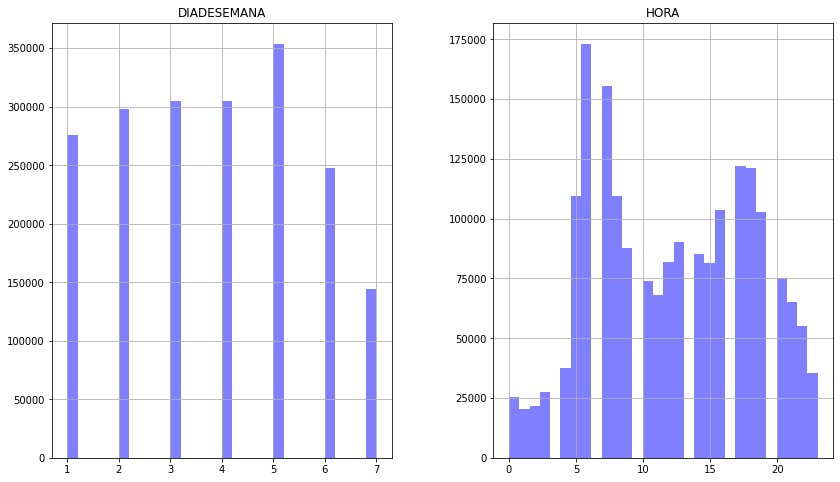

In [168]:
data.hist(bins=30, figsize=(14, 8), color="blue",alpha=0.5)
plot.show()

# Probando con función probabilistica

In [82]:
df_mp = df.copy()
df_mp = df_mp[df_mp["TELEFONOORIGEN"]=="3115590650"]


#Se llenan los datos faltantes
df_mp = completeServices(df_mp)

In [83]:
df_mp.head(5)

,TELEFONOORIGEN,DIADESEMANA,HORA,FECHA,SERVICIO
0,3115590650,5,0,2021-12-31,0
1,3115590650,5,1,2021-12-31,0
2,3115590650,5,2,2021-12-31,0
3,3115590650,5,3,2021-12-31,0
4,3115590650,5,4,2021-12-31,0


In [87]:
df_mp.loc[:,['TELEFONOORIGEN']].value_counts()

TELEFONOORIGEN
3115590650        3576
dtype: int64

Se muestra la probabilidad de un usuario con los datos de entrenamiento

In [91]:
def calculateProbabilisticModel(dataFrame):
  array_date_of_week = []
  for day in range(DAYS_OF_WEEK):
    array_hours = []
    for hour in range(HOURS_OF_DAY):
      array_hours.append( calculateProbability(hour, day+1, dataFrame))
    array_date_of_week.append(array_hours)
  return pd.DataFrame(np.array(array_date_of_week),
                    columns=[h for h in range(HOURS_OF_DAY)], index=["1-Monday","2-Tuesday","3-Wednesday","4-Thursday","5-Friday","6-Saturday","7-Sunday"],).transpose()

Se prueba con los datos de entrenamiento

In [95]:
calculateProbabilisticModel(train)

,1-Monday,2-Tuesday,3-Wednesday,4-Thursday,5-Friday,6-Saturday,7-Sunday
0,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
8,0.000,0.000,0.000,0.000,0.000000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000000,0.000,0.000


Se valida con los datos de pruebas

In [96]:
calculateProbabilisticModel(test)

,1-Monday,2-Tuesday,3-Wednesday,4-Thursday,5-Friday,6-Saturday,7-Sunday
0,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
1,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
2,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
3,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
4,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
5,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
6,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
7,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
8,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000
9,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000


# Exploración inicial

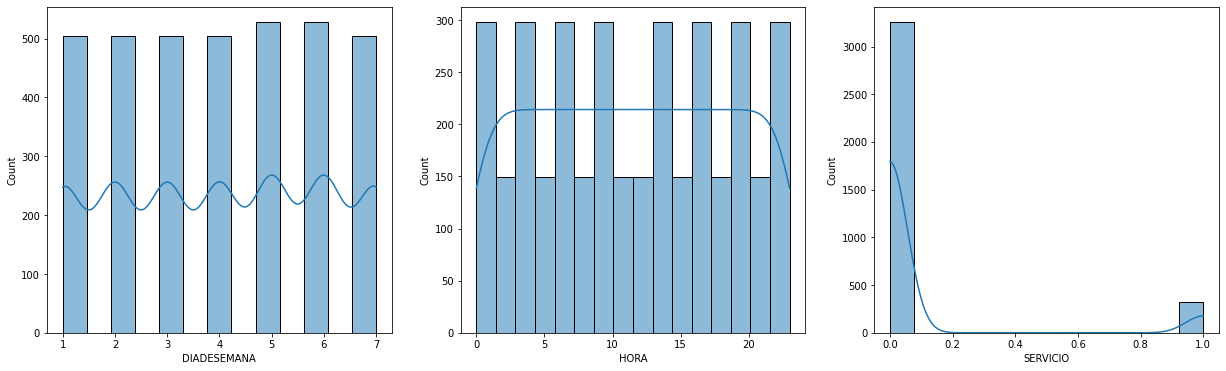

In [97]:
df_reg = df_mp.copy()
df_reg = df_reg.drop(columns=['TELEFONOORIGEN','FECHA'])
fig, axes = plot.subplots(1, 3)
fig.set_size_inches(21,6)
for i, column in enumerate(df_reg.columns):
  sns.histplot(df_reg[column], kde=True, ax=axes[i])

Se genera un diagrama de dispersión

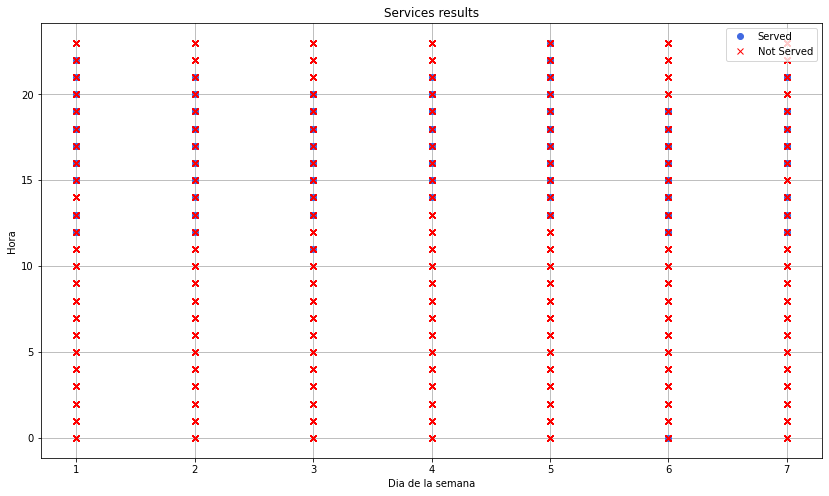

In [98]:
served = df_reg[df_reg.SERVICIO == 1]
not_served = df_reg[df_reg.SERVICIO == 0]

plot.figure(figsize=(14, 8))
plot.plot(served['DIADESEMANA'].values, served['HORA'].values, linestyle='', marker='o', color='royalblue', label='Served')
plot.plot(not_served['DIADESEMANA'].values, not_served['HORA'].values, linestyle='', marker='x', color='r', label='Not Served')
plot.title("Services results")
plot.legend()
plot.grid()
plot.xlabel('Dia de la semana')
plot.ylabel('Hora')
plot.show()

<AxesSubplot:>

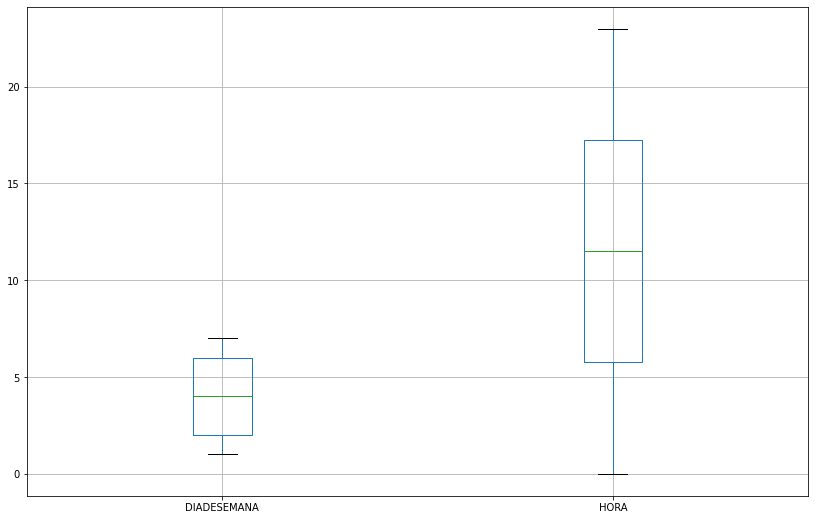

In [99]:
df_reg[['DIADESEMANA','HORA']].boxplot(figsize=(14,9))

Generando datos de prueba y entrenamiento

In [100]:
#CONJUNTO DE DATOS DE PRUEBA (20%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_reg, test_size=0.2, random_state=3, shuffle=True)
print(train)

      DIADESEMANA  HORA  SERVICIO
1042            6    10         0
588             1    12         0
2242            7    10         0
551             6    23         0
1037            6     5         0
...           ...   ...       ...
3000            4     0         0
1667            4    11         0
3321            3     9         0
1688            5     8         0
1898            7     2         0

[2860 rows x 3 columns]


In [101]:
#datos de entrenamiento
train.shape

(2860, 3)

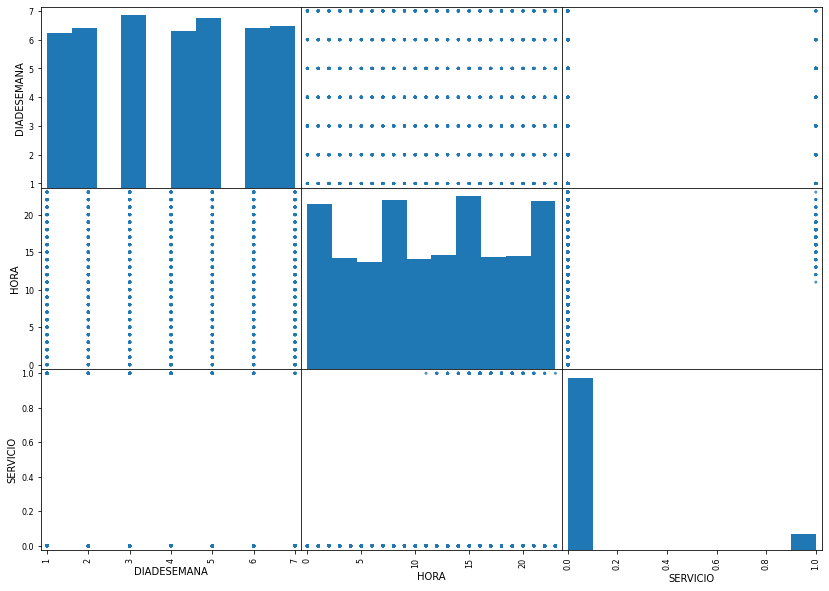

In [102]:
#Matriz de Dispersion con MatPlotLib
pd.plotting.scatter_matrix(train.loc[:,['DIADESEMANA','HORA','SERVICIO']], figsize=(14,10), alpha=0.8)
plot.show()

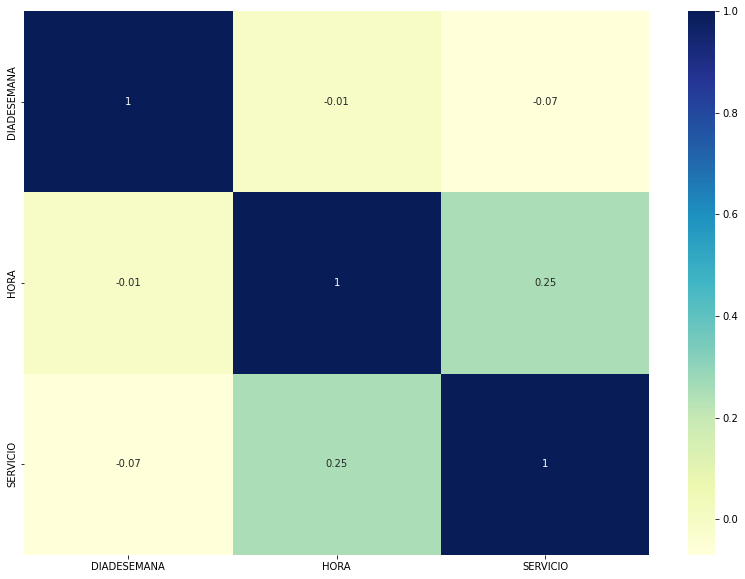

In [103]:
correlation_matrix = train.corr().round(2) 
fig, heat = plot.subplots(figsize = (14,10))
heat = sns.heatmap(data=correlation_matrix, annot=True, cmap="YlGnBu")
plot.show()

In [104]:
train.corr().SERVICIO.to_frame()

,SERVICIO
DIADESEMANA,-0.068639
HORA,0.245404
SERVICIO,1.000000


# Generación del modelo

In [105]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(train), columns=train.columns)
data.head()

,DIADESEMANA,HORA,SERVICIO
0,0.998798,-0.227844,-0.308134
1,-1.521550,0.061964,-0.308134
2,1.502868,-0.227844,-0.308134
3,0.998798,1.655913,-0.308134
4,0.998798,-0.952367,-0.308134


In [106]:
yrl = data.SERVICIO
features = ['HORA',	'DIADESEMANA']
Xrl = data[features]

##Evaluación de modelos##

ALGORITMO DE LOS KNN